In [1]:
from pca_dataflow_V2_variables import *

In [2]:
# Check if files exist
if os.path.exists(file):
    print(f"File exists: {file}")
else:
    print(f"File not found: {file}")

if os.path.exists(hdr_file):
    print(f"HDR File exists: {hdr_file}")
else:
    print(f"HDR File not found: {hdr_file}")

File exists: ../aviris_data/subzone_d/d_ang20220709t214748rfl/data/hs_raw_image\ang20220709t214748_rfl_v2aa2_img
HDR File exists: ../aviris_data/subzone_d/d_ang20220709t214748rfl/data/hs_raw_image\ang20220709t214748_rfl_v2aa2_img.hdr


In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

c:\Users\patri\anaconda3\envs\my_thesis_env\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
#test_array = img_open.ReadAsArray()

In [5]:
#test_array.shape

In [4]:
# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (RasterXSize):\t"+str(ncols),"Rows (RasterYSize):\t"+str(nrows)]))

Bands:	425
Cols (RasterXSize):	711
Rows (RasterYSize):	10610


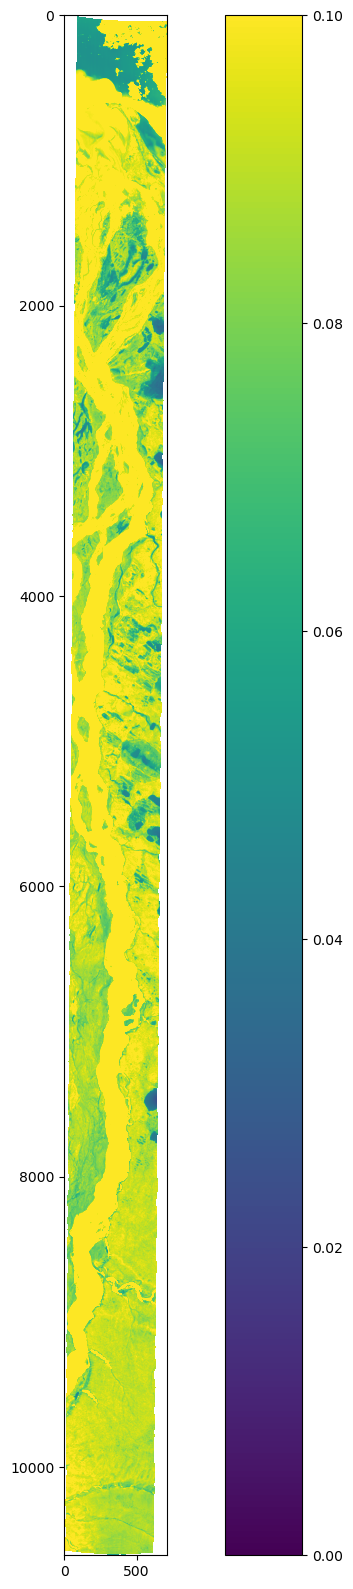

In [5]:
# read and display band 57 just to have a quick look at the image
img_red = img_open.GetRasterBand(57).ReadAsArray()
img_red = np.where(img_red == -9999, np.nan, img_red)
plt.rcParams["figure.figsize"] = [15,20]
plt.rcParams["figure.dpi"] = 100
plt.imshow(img_red,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

In [ ]:
'''
def save_array(output_path, array, num_bands, gdal_dataset, gdal_format = "GTiff", NoDataValue = -9999, data_type=gdal.GDT_Float32):
    """
    Saves a NumPy array as to a file.

    Args:
        output_path (str): The path to save the GeoTIF or ENVI file.
        array (numpy.ndarray): The NumPy array to save.
        num_bands (integer): Number of bands.
        gdal_dataset (gdal.Dataset): The GDAL dataset to use for geospatial information.
        gdal_format (str, optional): The GDAL format to use (default: "GTiff").
        NoDataValue (str or number): No data value. Usually -9999, 0 or np.nan.
        data_type (gdal.Datatype): GDT_Float32 or GDT_Byte 
    """
    driver = gdal.GetDriverByName(gdal_format)

    out_raster = driver.Create(
        output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        num_bands,
        data_type   
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())

    # Write the array band by band
    for i in range(num_bands):
        out_band = out_raster.GetRasterBand(i + 1)
        if num_bands == 1:
            out_band.WriteArray(array)
        else:
            #out_band.WriteArray(array[:, :, i])
            out_band.WriteArray(array[i])
        out_band.SetNoDataValue(NoDataValue)  # Or use 0 if appropriate
    out_raster.FlushCache()
'''

In [9]:
# Define NoData value
nodata_value = -9999

# Extract the required bands (band 57, 34, and 20)
band_57 = img_open.GetRasterBand(57).ReadAsArray()
band_34 = img_open.GetRasterBand(34).ReadAsArray()
band_20 = img_open.GetRasterBand(20).ReadAsArray()

# Replace NoData values with NaN (or any other appropriate value)
# set fill values (-9999.) to 0 for each array
band_57[band_57 == nodata_value], band_34[band_34 == nodata_value], band_20[band_20 == nodata_value] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
band_57_8bit, band_34_8bit, band_20_8bit = scale8bit(band_57), scale8bit(band_34), scale8bit(band_20)

# set rescaled fill pixels back to 0 for each array
band_57_8bit[band_57 == 0], band_34_8bit[band_34 == 0], band_20_8bit[band_20 == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = band_57_8bit, band_34_8bit, band_20_8bit

# Rearrange to (RasterCount, RasterYSize, RasterXSize)
reordered_rgb_stack = np.transpose(rgb_stack, (2, 0, 1))

In [ ]:
# Define output file path
RGB_file = os.path.join(input_dir, "output_rgb_image.tif")

# Save the RGB image as a GeoTIFF
save_array(RGB_file, reordered_rgb_stack,reordered_rgb_stack.shape[0], img_open,"GTiff",0,gdal.GDT_Byte)

print(f"RGB image saved as {RGB_file}")

In [ ]:
plt.figure(figsize=(15, 20))
plt.imshow(rgb_stack, cmap='bwr', interpolation='none')  # interpolation='none' ensures no smoothing
plt.colorbar(label='Shannon diversity index')
plt.title('Shannon diversity map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [2,12]
plt.rcParams["figure.dpi"] = 100
plt.imshow(rgb_stack)
plt.show()

In [ ]:
del band_57, band_34, band_20, band_57_8bit, band_34_8bit, band_20_8bit, rgb_stack
gc.collect()

# Calculate SAVI

In [ ]:
# Define band ranges for NIR, Green, and Red
nir_bands = range(86, 106)  # Bands 86 to 105 (1-based indexing in GDAL)
green_bands = range(26, 46)  # Bands 26 to 45
red_bands = range(56, 66)    # Bands 56 to 65

# Function to calculate the mean for a range of bands
def calculate_band_average(img, band_range):
    band_arrays = []
    for band_index in band_range:
        band_data = img.GetRasterBand(band_index).ReadAsArray()  # Read band
        band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace invalid values with NaN
        band_arrays.append(band_data)
    # Stack bands and calculate the mean along the 0th axis
    return np.nanmean(np.stack(band_arrays, axis=0), axis=0)

# Calculate averages for each range
nir_average = calculate_band_average(img_open, nir_bands)
green_average = calculate_band_average(img_open, green_bands)
red_average = calculate_band_average(img_open, red_bands)

In [ ]:
# Define SAVI parameters
SAVI_L = 0.5  # Adjust this based on your requirements
SAVI_threshold = 0.2  # Example threshold for vegetation identification

# Calculate the SAVI
SAVI = ((nir_average - red_average) * (1 + SAVI_L)) / (nir_average + red_average + SAVI_L)

# Create a SAVI mask
savi_mask = np.where(SAVI > SAVI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
#savi_mask = np.where(savi_mask == 0, np.nan, 1)

# Save SAVI and savi_mask

# ENVI format
SAVI_file_envi = os.path.join(input_dir, "SAVI")
SAVI_mask_file_envi = os.path.join(input_dir, "SAVI_mask")
save_array(SAVI_file_envi, SAVI, 1, img_open,"ENVI")
save_array(SAVI_mask_file_envi, savi_mask, 1, img_open,"ENVI")

#Geotiff format
SAVI_file = os.path.join(input_dir, "SAVI.tif")
SAVI_mask_file = os.path.join(input_dir, "SAVI_mask.tif")
save_array(SAVI_file, SAVI, 1, img_open,"GTiff")
save_array(SAVI_mask_file, savi_mask, 1, img_open,"GTiff")

print(f'SAVI mask saved as GTiff {SAVI_mask_file}')
print(f'SAVI mask saved as ENVI {SAVI_mask_file_envi}')
print(f'SAVI saved as GTiff {SAVI_mask_file}')
print(f'SAVI saved as ENVI {SAVI_file_envi}')

# Calculate NDWI

In [ ]:
# Formula: NDWI = (Green – NIR)/(Green + NIR)

# Define NDWI parameters
# The NDWI values correspond to the following ranges:
# 0,2 – 1 – Water surface,
# 0.0 – 0,2 – Flooding, humidity,
# -0,3 – 0.0 – Moderate drought, non-aqueous surfaces,
# -1 – -0.3 – Drought, non-aqueous surfaces

NDWI_threshold = 0.2

# Calculate the SAVI
NDWI = (green_average - nir_average)/(green_average + nir_average)

# Create a SAVI mask
ndwi_mask = np.where(NDWI > NDWI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
ndwi_mask = np.where(ndwi_mask == 0, np.nan, ndwi_mask)

# Save NDWI and ndwi_mask

# ENVI format
NDWI_file_envi = os.path.join(input_dir, "NDWI")
NDWI_mask_file_envi = os.path.join(input_dir, "NDWI_mask")
save_array(NDWI_file_envi, NDWI, 1, img_open,"ENVI")
save_array(NDWI_mask_file_envi, ndwi_mask, 1, img_open,"ENVI")

#Geotiff format
NDWI_file = os.path.join(input_dir, "NDWI.tif")
NDWI_mask_file = os.path.join(input_dir, "NDWI_mask.tif")
save_array(NDWI_file, NDWI, 1, img_open,"GTiff")
save_array(NDWI_mask_file, ndwi_mask, 1, img_open,"GTiff")

print(f'NDWI mask saved as GTiff {NDWI_mask_file}')
print(f'NDWI mask saved as ENVI {NDWI_mask_file_envi}')
print(f'NDWI saved as GTiff {NDWI_file}')
print(f'NDWI saved as ENVI {NDWI_file_envi}')

In [ ]:
del nir_bands, green_bands, red_bands, nir_average, green_average, red_average
gc.collect()

# Perform PCA

In [17]:
# File path
pca_model_file = os.path.join(input_dir, "pca_model.pkl")
pca_result_file = os.path.join(input_dir, "pca_result.npz")

In [ ]:
perform_pca = True

if(perform_pca):
    # Load the SAVI mask
    savi_mask_ds = gdal.Open(SAVI_mask_file)
    savi_mask = savi_mask_ds.GetRasterBand(1).ReadAsArray()
    savi_mask = np.where(savi_mask == 1, 1, np.nan)  # Keep only 1s, set others to NaN

    # Prepare hyperspectral image data
    bands = img_open.RasterCount  # Number of bands in the image
    rows, cols = savi_mask.shape

    # Initialize an empty list to store valid pixel data
    valid_pixels = []

    # Define the bands to include based on bblist
    bblist = np.ones((425,))
    bblist[0:14] = 0
    bblist[189:225] = 0
    bblist[281:336] = 0
    bblist[405:] = 0

    # Convert bblist to boolean mask for included bands
    included_bands = np.where(bblist == 1)[0] + 1  # GDAL bands are 1-based
    num_included_bands = len(included_bands)

    # Loop through only the included bands
    valid_pixels = []
    for band_index in included_bands:
        band_data = img_open.GetRasterBand(int(band_index)).ReadAsArray()
        band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace no-data values with NaN
        # Apply mask
        masked_data = band_data * savi_mask  # Retain only pixels where mask == 1
        valid_pixels.append(masked_data)

    # Stack all bands into a single 3D array (bands, rows, cols)
    image_stack = np.stack(valid_pixels, axis=0)

    # Flatten the image stack (bands, rows*cols) and remove NaN
    flattened_pixels = image_stack.reshape(num_included_bands, -1).T  # Shape: (pixels, included_bands)
    filtered_pixels = flattened_pixels[~np.isnan(flattened_pixels).any(axis=1)]  # Exclude NaN

    # Standardize the data (scaling)
    scaler = StandardScaler()
    filtered_pixels_scaled = scaler.fit_transform(filtered_pixels)

    # Perform PCA
    #n_components = 30  # Maximum number of PCs to retain
    #pca = PCA(n_components=n_components)

    variance_to_retaine = 0.999
    pca = PCA(n_components=variance_to_retaine)

    pca_result = pca.fit_transform(filtered_pixels_scaled)  # Shape: (valid_pixels, n_components)

    # The number of components remaining
    num_components = pca.n_components_
    num_selected_pcs = num_components
    print(f'Number of components to retain {pca.n_components*100}% variance: {num_components}')

    # Save PCA model using pickle
    with open(pca_model_file, "wb") as f:
        pickle.dump(pca, f)

    # Save PCA-transformed data using NumPy
    np.savez(pca_result_file, pca_result=pca_result)

In [19]:
load_model = False

if(load_model):
    # Load PCA model
    with open(pca_model_file, "rb") as f:
        loaded_pca = pickle.load(f)

    # Load PCA-transformed data
    loaded_data = np.load(pca_result_file)
    pca_result = loaded_data["pca_result"]

In [20]:
#explained_variance_threshold = 0.999

# Select PCs that explain 99% variance
#num_selected_pcs = np.searchsorted(cumulative_variance, explained_variance_threshold) + 1  # Find index where cumulative variance >= 99%
#selected_pcs = pca_result[:, :num_selected_pcs]  # Retain only the selected PCs
all_pcs = pca_result[:, :]


In [ ]:
del pca_result
gc.collect()

In [ ]:
# Create a vector of selected component numbers
selected_component_numbers = list(range(1, num_components + 1))

print(f"PCs selected: {selected_component_numbers}")

# File path
pc_number_file = os.path.join(input_dir, "Selected_Components.txt")

# Open the file in write mode
with open(pc_number_file, "w") as file:
    # Write each number on a new line
    for i in range(1, num_selected_pcs + 1):
        file.write(f"{i}\n")

print(f"Optimal number of clusters saved to {pc_number_file}.")

In [23]:
# Reshape selected PCs back to spatial dimensions
#reshaped_selected_pcs = np.full((num_selected_pcs, rows, cols), np.nan)  # Initialize with NaN
reshaped_pcs = np.full((num_components, rows, cols), np.nan)  # Initialize with NaN
valid_indices = np.where(~np.isnan(flattened_pixels).any(axis=1))[0]

# reshape selected PCs
#for pc_index in range(num_selected_pcs):
#    reshaped_selected_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = selected_pcs[:, pc_index]

# reshape all PCs
for pc_index in range(num_components):
    reshaped_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = all_pcs[:, pc_index]

In [ ]:
'''
# Save each PC as a separate band in a GeoTIFF
def save_multiband_tif(output_path, data, gdal_dataset):
    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        data.shape[0],  # Number of bands
        gdal.GDT_Float32
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())
    
    for band_index in range(data.shape[0]):
        out_band = out_raster.GetRasterBand(band_index + 1)
        out_band.WriteArray(data[band_index])
        out_band.SetNoDataValue(np.nan)
    
    out_raster.FlushCache()
'''

# Save the selected PCs as a GeoTIFF
#PCA_selection_file = os.path.join(input_dir, "PCA_selected.tif")
#save_multiband_tif(PCA_selection_file, reshaped_selected_pcs, img_open)

PCA_file = os.path.join(input_dir, "PCA.tif")
save_array(PCA_file, reshaped_pcs, reshaped_pcs.shape[0], img_open,"GTiff")

#save_multiband_tif(PCA_file, reshaped_pcs, img_open)

print(f'PCA file saved as {PCA_file}')

In [ ]:
# Save the selected PCs as a GeoTIFF
Rectified_PCA_file = os.path.join(input_dir, "PCA_rectified")
#Rectified_PCA_selection_file = os.path.join(input_dir, "PCA_selection_rectified")

# Construct the GDAL command
gdal_command_rectify = [
    "gdalwarp",
    "-of", "ENVI",                   # Output format
    "-co", "INTERLEAVE=BIL",         # Create ENVI format with BIL interleaving
    "-dstnodata", "-9999",           # Set nodata value
    PCA_file,
    Rectified_PCA_file
]

# Execute the command in Python
try:
    subprocess.run(gdal_command_rectify, check=True)
    print(f"Rectified image saved to {Rectified_PCA_file}")
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")

In [ ]:
'''
# Define the total number of bands
#total_bands = nbands

# Define the ranges of bands to exclude
#exclude_1 = range(1, 4)  # Excludes bands 1, 2, 3
#exclude_2 = range(6, 9)  # Excludes bands 6, 7, 8
#exclude_3 = range(11, 16)  # Excludes bands 6, 7, 8

# Combine all the excluded ranges into one list
#excluded_bands = set(exclude_1).union(exclude_2).union(exclude_3)

# Get the list of all band indices
all_bands = list(range(1, num_selected_pcs + 1))

# Exclude the specified bands
# remaining_bands = [str(band) for band in all_bands if band not in excluded_bands]

# Create the string in the desired format
rem_bands = " ".join([f"-b {band}" for band in all_bands])
# Split the string into a list
band_selection_args = rem_bands.split()
#band_selection_args = str(band_selection_args)[1:-1]

# Print the result
print(rem_bands)
print(band_selection_args)
'''

In [ ]:
'''
def gdal_transform(band_sel, input_file, output_file, output_format):
    # Construct the GDAL command
    gdal_command_subbands = [
        "gdal_translate",
        *band_sel,       #Unpack with asteriks
        "-of", 
        output_format,                   # Output format
        input_file,
        output_file
    ]

    print(gdal_command_subbands)

    # Execute the command in Python
    try:
        result = subprocess.run(gdal_command_subbands, check=True, text=True, capture_output=True)
        print(f"Command succeeded:\n{result.stdout}")
    except subprocess.CalledProcessError as e:
        print(f"Command failed:\n{e.stderr}")
'''

In [ ]:
'''
PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection")
gdal_transform(band_selection_args,PCA_file,PCA_selection_file,"ENVI")
'''

In [ ]:
'''
PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection.tif")
gdal_transform(band_selection_args,PCA_file,PCA_selection_file,"GTiff")
'''

# Reset workspace

In [30]:
%reset -f

In [31]:
from pca_dataflow_V2_variables import *

# Perform WSS Elbow Method

In [32]:
PCA_selection_file = os.path.join(input_dir, "PCA.tif")

In [33]:
# open the hyperspectral image file with GDAL
img_open_pca_selection = gdal.Open(PCA_selection_file)

In [ ]:
# read a few key properties of the image
bands = img_open_pca_selection.RasterCount
cols = img_open_pca_selection.RasterXSize
rows = img_open_pca_selection.RasterYSize

print("\n".join(["Bands:\t"+str(bands),"Cols (RasterXSize):\t"+str(cols),"Rows (RasterYSize):\t"+str(rows)]))

In [ ]:
'''
# Initialize an empty array to hold the data
pca_data_selection = np.empty((nbands_sel, nrows_sel, ncols_sel), dtype=np.float32)
# Read each band into the array
for i in range(nbands_sel):
    band = img_open_pca_selection.GetRasterBand(i + 1)
    pca_data_selection[i] = band.ReadAsArray()
'''

In [ ]:
pca_data_selection = img_open_pca_selection.ReadAsArray()
print(f'Dimensions {pca_data_selection.shape}')

In [37]:
pca_selection_data = img_open_pca_selection.ReadAsArray()
pca_data_selection_2d = pca_selection_data.reshape(bands, -1).T

# Remove pixels with NaN values
valid_pixels = pca_data_selection_2d[~np.isnan(pca_data_selection_2d).any(axis=1)]

In [ ]:
valid_pixels_unique_count = np.unique(valid_pixels, axis=0)
print(f"Number of unique pixels: {valid_pixels_unique_count.shape[0]}")
print("Valid pixels shape:", valid_pixels.shape)

In [ ]:
''' 
# Step 3: Apply the elbow method
# Range of cluster counts to try
k_range = range(1, 30)
wcss = []  # Within-cluster sum of squares

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1)
    kmeans.fit(valid_pixels)
    wcss.append(kmeans.inertia_)
    print(f'Cluster {k} processed')

# Step 4: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

# Step 5: Determine optimal k (manual inspection or heuristic)
optimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic
print(f"Optimal number of clusters: {optimal_k}")
''' 

In [ ]:
# Define function to compute WCSS for a single value of k
def compute_wcss(k, data):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1)
    kmeans.fit(data)
    #print(f'Cluster {k} processed')
    return kmeans.inertia_

# Parallel computation of WCSS
k_range = range(1, 30)  # Define the range of cluster counts to try
#num_cores = -1  # Use all available cores (-1)

num_cores = os.cpu_count() - 2  # Reserve 2 cores for the system
if num_cores < 1:
    num_cores = 1  # Ensure at least one core is used

wcss = Parallel(n_jobs=num_cores)(
    delayed(compute_wcss)(k, valid_pixels) for k in k_range
)

#print("WCSS for all cluster values:", wcss)

# Step 4: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

# Step 5: Determine optimal k (manual inspection or heuristic)
optimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic
print(f"Optimal number of clusters: {optimal_k}")


In [41]:
spectral_species_file = os.path.join(input_dir, "spectral_species.tif")

In [42]:
# Step 2: Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
cluster_labels = kmeans.fit_predict(valid_pixels)

# Step 3: Reshape clustered data back into spatial dimensions
cluster_image = np.full((rows, cols), -9999, dtype=int)  # Initialize with NaN
valid_indices = np.where(~np.isnan(pca_data_selection_2d).any(axis=1))[0]
cluster_image[np.unravel_index(valid_indices, (rows, cols))] = cluster_labels

In [ ]:
# Mask the no-data values (-9999)
masked_image = np.ma.masked_where(cluster_image == -9999, cluster_image)

# Plot the image with transparency for no-data values
plt.figure(figsize=(15, 20))
plt.imshow(masked_image, cmap='viridis', interpolation='none')  # interpolation='none' ensures no smoothing
plt.colorbar(label='Cluster Labels')
plt.title('Spectral species map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
save_array(spectral_species_file, cluster_image, 1, img_open_pca_selection,"GTiff")
print(f'Spectral species file saved as {spectral_species_file}')

'''
# Step 4: Save the clustered image as GeoTIFF
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(
    spectral_species_file, cols, rows, 1, gdal.GDT_Int32
)

# Copy georeferencing information from PCA file
out_raster.SetGeoTransform(img_open_pca_selection.GetGeoTransform())
out_raster.SetProjection(img_open_pca_selection.GetProjection())

# Write cluster labels
out_band = out_raster.GetRasterBand(1)
out_band.WriteArray(cluster_image)
out_band.SetNoDataValue(-9999)  # Set NoData value for invalid pixels
out_band.FlushCache()

# Close datasets
out_raster = None
ds = None

print(f"K-means clustering result saved to {spectral_species_file}")
'''

In [ ]:
'''
# Step 4: Save the clustered image as GeoTIFF
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(
    output_cluster_file, ncols_sel, nrows_sel, 1, gdal.GDT_Int32
)

# Copy georeferencing information from PCA file
out_raster.SetGeoTransform(img_open_pca_selection.GetGeoTransform())
out_raster.SetProjection(img_open_pca_selection.GetProjection())

# Write cluster labels
out_band = out_raster.GetRasterBand(1)
out_band.WriteArray(cluster_image)
out_band.SetNoDataValue(-9999)  # Set NoData value for invalid pixels
out_band.FlushCache()

# Close datasets
out_raster = None
ds = None


print(f"K-means clustering result saved to {output_cluster_file}")
'''

In [ ]:
'''
import skbio.diversity.alpha as alpha
import numpy as np

# Assuming 'counts' is an array of cluster frequencies
shannon = alpha.shannon(counts)
simpson = alpha.simpson(counts)
'''

In [47]:
%reset -f

In [48]:
from pca_dataflow_V2_variables import *

In [49]:
output_cluster_file = os.path.join(input_dir, "spectral_species.tif")

In [50]:
# open the hyperspectral image file with GDAL
spectral_species_img = gdal.Open(output_cluster_file)

In [ ]:
spectral_species_img_array = spectral_species_img.ReadAsArray()
print(spectral_species_img_array.shape)

In [ ]:
# Mask no-data values (-9999) by excluding them
valid_pixels = spectral_species_img_array[spectral_species_img_array != -9999]

print("Valid pixels:", valid_pixels)

In [ ]:
# Calculate frequencies for valid clusters
unique, counts = np.unique(valid_pixels, return_counts=True)

# Convert to float for diversity calculations
counts = counts.astype(float)

print("Cluster frequencies:", counts)

In [ ]:


# Shannon diversity
shannon_index = alpha.shannon(counts)

# Simpson diversity
simpson_index = alpha.simpson(counts)

print(f"Shannon Index: {shannon_index}")
print(f"Simpson Index: {simpson_index}")

In [ ]:
import numpy as np
from osgeo import gdal, osr
from scipy.ndimage import generic_filter


def calculate_shannon_diversity(window):
    """
    Calculate Shannon diversity index for a given window of cluster values.
    """
    # Remove no-data values
    valid_values = window[window != -9999]
    if len(valid_values) == 0:
        return -9999  # No valid data in the window

    # Compute the frequency of each cluster
    unique, counts = np.unique(valid_values, return_counts=True)
    probabilities = counts / counts.sum()

    # Calculate Shannon diversity index
    shannon_diversity = -np.sum(probabilities * np.log(probabilities))
    return shannon_diversity


def create_shannon_diversity_map(input_file, output_file, window_size):
    """
    Generate a Shannon diversity map from a GeoTIFF containing cluster data.

    Args:
        input_file (str): Path to the input GeoTIFF file.
        output_file (str): Path to save the output GeoTIFF file.
        window_size (int): Window size for computing Shannon diversity.
    """
    # Open the input GeoTIFF
    dataset = gdal.Open(input_file)
    band = dataset.GetRasterBand(1)
    input_array = band.ReadAsArray()

    # Get geo-information from the input dataset
    geotransform = dataset.GetGeoTransform()
    projection = dataset.GetProjection()
    no_data_value = band.GetNoDataValue()

    # Apply the Shannon diversity calculation using a sliding window
    diversity_map = generic_filter(
        input_array,
        function=calculate_shannon_diversity,
        size=(window_size, window_size),
        mode='constant',
        cval=no_data_value
    )

    # Save the Shannon diversity map as a GeoTIFF
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(
        output_file,
        dataset.RasterXSize,
        dataset.RasterYSize,
        1,
        gdal.GDT_Float32
    )
    out_dataset.SetGeoTransform(geotransform)
    out_dataset.SetProjection(projection)

    # Write the Shannon diversity data and set no-data value
    out_band = out_dataset.GetRasterBand(1)
    out_band.WriteArray(diversity_map)
    out_band.SetNoDataValue(-9999)

    # Save and close datasets
    out_band.FlushCache()
    out_dataset = None
    dataset = None
    print(f"Shannon diversity map saved to {output_file}")


# Example Usage
input_file = os.path.join(input_dir, "spectral_species.tif")
shannon_diversity_map_file = os.path.join(input_dir, "shannon_diversity_map.tif")  # Replace with desired output file path
window_size = 10  # Example window size

create_shannon_diversity_map(input_file, shannon_diversity_map_file, window_size)

In [ ]:
# Mask the no-data values (-9999)
shannon_diversity_map_data = gdal.Open(shannon_diversity_map_file).ReadAsArray()
shannon_diversity_map_data_masked_image = np.ma.masked_where(shannon_diversity_map_data == -9999, shannon_diversity_map_data)

# Plot the image with transparency for no-data values
plt.figure(figsize=(15, 20))
plt.imshow(shannon_diversity_map_data_masked_image, cmap='bwr', interpolation='none')  # interpolation='none' ensures no smoothing
plt.colorbar(label='Shannon diversity index')
plt.title('Shannon diversity map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()